In [6]:
from ollama import chat
from pydantic import BaseModel
from typing import List, Literal, Optional
import numpy as np
import os
from dotenv import load_dotenv
from PIL import Image

load_dotenv()

PROJECT_DIR = os.getenv("PROJECT_DIR")
DEAL_ANNOTATION_PATH = os.path.join(PROJECT_DIR, "labeled_deals_gabriel.csv")
LEAFLET_DIR = os.path.join(PROJECT_DIR, "crawled_leaflets")
DABASE_PATH = os.path.join(LEAFLET_DIR, "supermarket_leaflets.db")
DEALS_DIR = os.path.join(PROJECT_DIR, "deals")
MODELS_DIR = os.path.join(PROJECT_DIR, "models")

In [7]:
all_images = []

for root, dirs, files in os.walk(DEALS_DIR):
    for file in files:
        if file.endswith(".png") and "annotated" not in file:
            all_images.append(os.path.join(root, file))

In [8]:
rnd_image = np.random.choice(all_images)
loaded_image = Image.open(rnd_image).convert("RGB")

In [9]:
class DealDescription(BaseModel):
    brand: Optional[str] = None
    productname: str
    original_price: Optional[float] = None
    deal_price: float
    amount: Optional[str] = None

brand=None productname='Felix Katzennahrung' original_price=None deal_price=3.99 amount='1 kg'


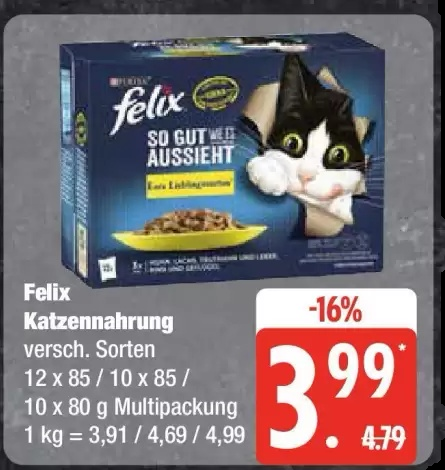

In [10]:
response = chat(
    model="llama3.2-vision",
    format=DealDescription.model_json_schema(),  # Pass in the schema for the response
    messages=[
        {
            "role": "user",
            "content": (
                """
                You are an advanced language model specializing in structured data extraction from OCR text. Your task is to extract structured information from a supermarket deal OCR result.

                Extraction Fields:
                    - brand: The brand name, if available (e.g. "Coca Cola", "Milka", "Nestle", "Müller", "Iglo").
                    - productname: The name of the product without mentioning the brand and description.
                    - original_price: The original price of the product, if given (often strikethrough).
                    - deal_price: The price of the product on sale (e.g. 1.99, 2.50, 0.99). Never negative.
                    - amount: The amount of the product, if given (e.g. 500g, 1kg, 1 piece).
                """
            ),
            "images": [rnd_image],
        },
    ],
    options={"temperature": 0}, # Set the temperature to 0 to get deterministic results
)

image_description = DealDescription.model_validate_json(response.message.content)
print(image_description)
loaded_image

brand=None productname='Felix Katzennahrung' original_price=None deal_price=3.99 amount='1 kg = 3,91 / 4,69 / 4,99'


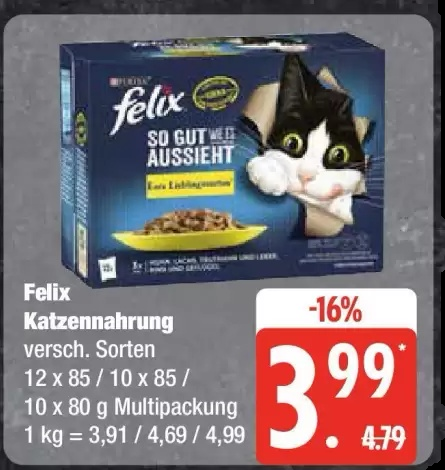

In [11]:
response = chat(
    model="minicpm-v",
    format=DealDescription.model_json_schema(),  # Pass in the schema for the response
    messages=[
        {
            "role": "user",
            "content": (
                """
                You are an advanced language model specializing in structured data extraction from OCR text. Your task is to extract structured information from a supermarket deal OCR result.

                Extraction Fields:
                    - brand: The brand name, if available (e.g. "Coca Cola", "Milka", "Nestle", "Müller", "Iglo").
                    - productname: The name of the product without mentioning the brand and description.
                    - original_price: The original price of the product, if given (often strikethrough).
                    - deal_price: The price of the product on sale (e.g. 1.99, 2.50, 0.99). Never negative.
                    - amount: The amount of the product, if given (e.g. 500g, 1kg, 1 piece).
                """
            ),
            "images": [rnd_image],
        },
    ],
    options={"temperature": 0}, # Set the temperature to 0 to get deterministic results
)

image_description = DealDescription.model_validate_json(response.message.content)
print(image_description)
loaded_image